In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from types import SimpleNamespace
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, psiam_tied_data_gen_wrapper_rate_norm_fn

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# exp fixation

In [3]:
V_A = 1.596
theta_A = 2.531
t_A_aff = -0.226
del_go = 0.13

In [4]:
rate_lambda  = 0.13
T_0    = 0.45 * 1e-3
theta_E       = 45 
Z_E           = 0
t_E_aff       = 68 * 1e-3
rate_norm_l   = 0
bump_height = 0.35843
bump_width = 0.28042
dip_height = 0.29913
dip_width = 0.01818
bump_offset = 0

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [5]:
N_sim = int(1e6)
t_stim_samples_exp_fix = np.random.exponential(scale=0.4, size=N_sim) + 0.2
ABL_samples = df['ABL'].sample(N_sim, replace=True).values
ILD_samples = df['ILD'].sample(N_sim, replace=True).values


N_print = int(N_sim / 5)
dt  = 1e-4

sim_results_exp_fix = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples_exp_fix[iter_num], rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 1120201, In iter_num: 0, ABL: 60, ILD: 2.0, t_stim: 0.4315720947279156
os id: 1120259, In iter_num: 200000, ABL: 40, ILD: 1.0, t_stim: 0.43794990074525525
os id: 1120204, In iter_num: 400000, ABL: 40, ILD: 8.0, t_stim: 0.36694080486583397
os id: 1120249, In iter_num: 600000, ABL: 40, ILD: 2.0, t_stim: 0.920160322756874
os id: 1120257, In iter_num: 800000, ABL: 40, ILD: -8.0, t_stim: 0.4574463607604818


# uniform fix

In [30]:
t_stim_samples_unif_fix = np.random.uniform(0.300, 0.350, N_sim)

V_A_1 = V_A
sim_results_unif_fix = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A_1, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples_unif_fix[iter_num], rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 1126035, In iter_num: 0, ABL: 60, ILD: 2.0, t_stim: 0.32866698569094177
os id: 1126059, In iter_num: 200000, ABL: 40, ILD: 1.0, t_stim: 0.3482598424780105
os id: 1126054, In iter_num: 400000, ABL: 40, ILD: 8.0, t_stim: 0.3179405991150929
os id: 1126047, In iter_num: 600000, ABL: 40, ILD: 2.0, t_stim: 0.30118436084024786
os id: 1126063, In iter_num: 800000, ABL: 40, ILD: -8.0, t_stim: 0.3372048652091456


# compare uniform fix and exp fix

In [31]:
exp_fix_df = pd.DataFrame(sim_results_exp_fix)
unif_fix_df = pd.DataFrame(sim_results_unif_fix)

exp_fix_rt = exp_fix_df['rt'] - exp_fix_df['t_stim']
unif_fix_rt = unif_fix_df['rt'] - unif_fix_df['t_stim']

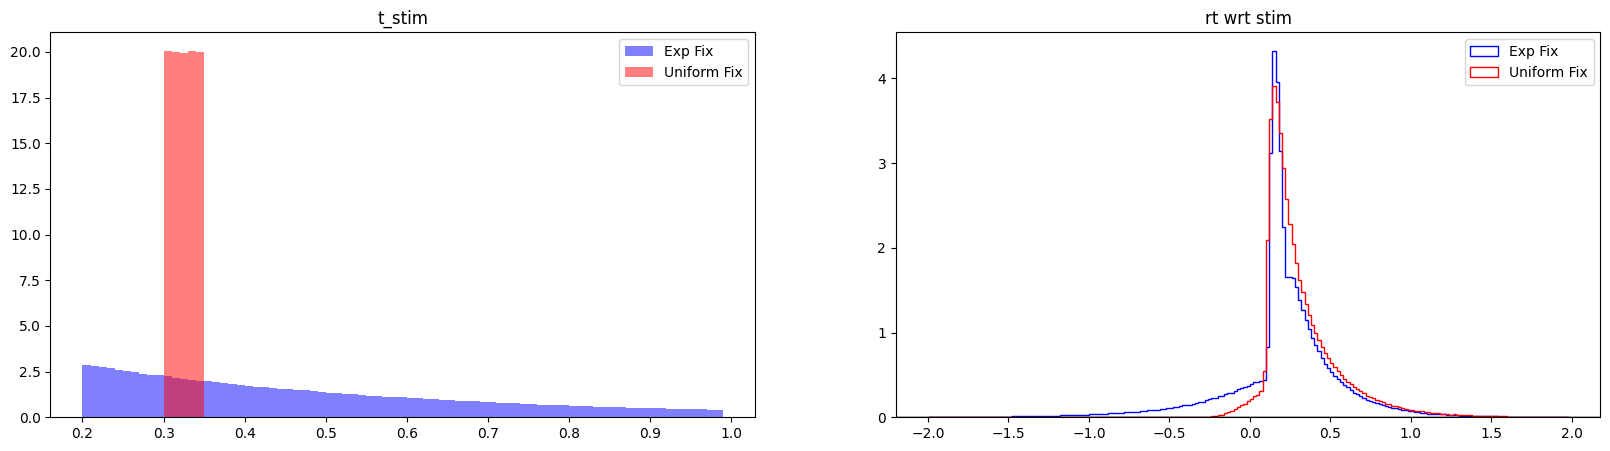

In [32]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
t_stim_bins = np.arange(0.2, 1, 0.01)
plt.hist(t_stim_samples_exp_fix, bins=t_stim_bins, alpha=0.5, label='Exp Fix', color='b', density=True)
plt.hist(t_stim_samples_unif_fix, bins=t_stim_bins, alpha=0.5, label='Uniform Fix', color='r', density=True)
plt.legend();
plt.title('t_stim')

plt.subplot(1,2,2)
bins = np.arange(-2, 2, 0.02)
plt.hist(exp_fix_rt, label='Exp Fix', color='b', density=True, histtype='step', bins=bins)
plt.hist(unif_fix_rt, label='Uniform Fix', color='r', density=True, histtype='step', bins=bins)
plt.axhline(0, color='k', alpha=0.3)
plt.legend();
plt.title('rt wrt stim')
plt.show()

